In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob
import cv2 as cv2
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Dropout
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Loss, binary_crossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU

# Constants

In [2]:
BATCH_SIZE = 32
DIM = 256
CONV_BASE_FILTERS = 16

# Data processing

In [3]:
path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/'

In [4]:
masks = glob.glob(path + '*/*_mask.tif*')

images = []
abnormalities = []

for mask in tqdm(masks):
    images.append(mask[:-9]+'.tif')
    if np.max(cv2.imread(mask)) > 0:
        abnormalities.append(1)
    else:
        abnormalities.append(0)

print('\n Check if the lists are correctly built ...\n')
print('Amount of \n - images : {}\n - masks: {}\n - abnormalities: {} \n'.format(len(images), len(masks), len(abnormalities)))
print('Type in the lists of \n - images : {}\n - masks: {}\n - abnormalities: {} \n'.format(type(images[0]), type(masks[0]), type(abnormalities[0])))

100%|██████████| 3929/3929 [00:26<00:00, 149.74it/s]


 Check if the lists are correctly built ...

Amount of 
 - images : 3929
 - masks: 3929
 - abnormalities: 3929 

Type in the lists of 
 - images : <class 'str'>
 - masks: <class 'str'>
 - abnormalities: <class 'int'> 



In [5]:
paths = pd.DataFrame({'image': images,'mask': masks,'abnormality': abnormalities})

paths.head()

,image,mask,abnormality
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1


# Data analysis

In [6]:
train, test = train_test_split(paths, stratify=paths['abnormality'], test_size=0.15, random_state=0)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

train, validation = train_test_split(paths, stratify=paths['abnormality'], test_size=0.1, random_state=0)
train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)

print('Amount of samples used for : \n - training : {}\n - validation : {}\n - testing : {}'.format(train.shape[0], validation.shape[0], test.shape[0]))

Amount of samples used for : 
 - training : 3536
 - validation : 393
 - testing : 590


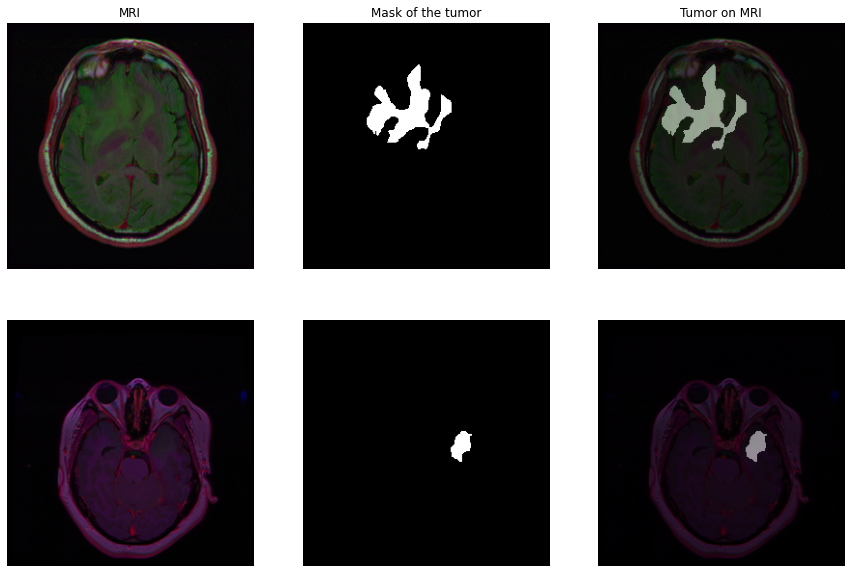

In [7]:
SAMPLES_TO_OBSERVE = 2

random_with_abnormality = paths[paths['abnormality']==1].sample(SAMPLES_TO_OBSERVE)

f, ax = plt.subplots(SAMPLES_TO_OBSERVE,3, figsize=(15,10))
[axi.set_axis_off() for axi in ax.ravel()]
for i in range(SAMPLES_TO_OBSERVE):
    img = cv2.imread(random_with_abnormality.iloc[i]['image'])
    msk = cv2.imread(random_with_abnormality.iloc[i]['mask'])
    blend = cv2.addWeighted(img, 0.5, msk, 0.5, 0.)
    ax[i,0].imshow(img)
    ax[i,1].imshow(msk)
    ax[i,2].imshow(blend)
    if i==0:
        ax[i,0].set_title('MRI')
        ax[i,1].set_title('Mask of the tumor')
        ax[i,2].set_title('Tumor on MRI')

# Data Generator

In [8]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, dataframe, batch_size, dim, shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.dim = dim
        self.indices = self.dataframe.index.tolist()
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, list_IDs_temp):
        batch_images = np.empty((self.batch_size, self.dim, self.dim, 3))
        batch_masks = np.empty((self.batch_size, self.dim, self.dim, 1))
        for i,_id in enumerate(list_IDs_temp):
            img = cv2.imread(self.dataframe.iloc[_id]['image'])
            img = img/255.
            if self.dim!=img.shape[1]:
                img = cv2.resize(img, (self.dim, self.dim), interpolation= cv2.INTER_LINEAR)
            batch_images[i]=img
            
            msk = cv2.imread(self.dataframe.iloc[_id]['mask'], cv2.IMREAD_GRAYSCALE)
            msk = msk/255.
            if self.dim!=msk.shape[1]:
                msk = cv2.resize(msk, (self.dim, self.dim), interpolation= cv2.INTER_LINEAR)
            msk = np.expand_dims(msk, axis=-1)
            batch_masks[i]=msk
        return batch_images,batch_masks

In [9]:
train_generator = DataGenerator(train, BATCH_SIZE, DIM)
validation_generator = DataGenerator(validation, BATCH_SIZE, DIM)

# UNet : construction

In [10]:
class DecoderCell(Layer):
    def __init__(self, filters, dropout_rate, kernel_size):
        super(DecoderCell, self).__init__()
        self.trans_conv = Conv2DTranspose(filters, kernel_size, strides = (2, 2), padding = 'same')
        self.dropout = Dropout(dropout_rate)
        self.double_conv = DoubleConv2D(filters, kernel_size)

    def call(self, VerticalConvInput, HorizontalConvInput):
        x = self.trans_conv(VerticalConvInput)
        x = Concatenate()([x, HorizontalConvInput])
        x = self.dropout(x)
        VerticalConvOutput = self.double_conv(x)

        return VerticalConvOutput

class EncoderCell(Layer):

    def __init__(self, filters, kernel_size, dropout_rate):
        super(EncoderCell, self).__init__()
        self.double_conv = DoubleConv2D(filters, kernel_size)
        self.maxpool = MaxPool2D((2, 2))
        self.dropout = Dropout(dropout_rate)
    
    def call(self, input_tensor):
        conv_output = self.double_conv(input_tensor)
        pool_output = self.maxpool(conv_output)
        pool_output = self.dropout(pool_output)

        return conv_output, pool_output
    
class DoubleConv2D(Layer):

    def __init__(self, filters, kernel_size):
        super(DoubleConv2D, self).__init__()
        self.conv1 = Conv2D(filters = filters, kernel_size = kernel_size, kernel_initializer = 'he_normal', padding = 'same')
        self.batchnorm1 = BatchNormalization()
        self.conv2 = Conv2D(filters = filters, kernel_size = kernel_size, kernel_initializer = 'he_normal', padding = 'same')
        self.batchnorm2 = BatchNormalization()
        
    def call(self, input_tensor):    
        x = self.conv1(input_tensor)
        x = self.batchnorm1(x)
        x = Activation('relu')(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = Activation('relu')(x)
        return x

class UNet(Model):

    def __init__(self, n_filters, dropout_rate):

        super(UNet, self).__init__()

        self.EncoderCell_1 = EncoderCell(filters = n_filters * 1, kernel_size = 3, dropout_rate = dropout_rate)

        self.EncoderCell_2 = EncoderCell(filters = n_filters * 2, kernel_size = 3, dropout_rate = dropout_rate)
        
        self.EncoderCell_3 = EncoderCell(filters = n_filters * 4, kernel_size = 3, dropout_rate = dropout_rate)

        self.EncoderCell_4 = EncoderCell(filters = n_filters * 8, kernel_size = 3, dropout_rate = dropout_rate)
        
        self.transition_double_conv = DoubleConv2D(filters = n_filters * 16, kernel_size = 3)
        
        self.decoderCell_1 = DecoderCell(filters = n_filters * 8, kernel_size = 3, dropout_rate = dropout_rate)

        self.decoderCell_2 = DecoderCell(filters = n_filters * 4, kernel_size = 3, dropout_rate = dropout_rate)
        
        self.decoderCell_3 = DecoderCell(filters = n_filters * 2, kernel_size = 3, dropout_rate = dropout_rate)

        self.decoderCell_4 = DecoderCell(filters = n_filters * 1, kernel_size = 3, dropout_rate = dropout_rate)
        
        self.final_conv = Conv2D(1, (1, 1), activation='sigmoid')

    def build(self, input_shape):
        super(UNet, self).build(input_shape)
    
    def call(self, inputs):

        conv_output1, pooling_output1 = self.EncoderCell_1(inputs)

        conv_output2, pooling_output2 = self.EncoderCell_2(pooling_output1)
        
        conv_output3, pooling_output3 = self.EncoderCell_3(pooling_output2)

        conv_output4, pooling_output4 = self.EncoderCell_4(pooling_output3)

        conv_output5 = self.transition_double_conv(pooling_output4)
        
        conv_output6 = self.decoderCell_1(conv_output5, conv_output4)

        conv_output7 = self.decoderCell_2(conv_output6, conv_output3)
        
        conv_output8 = self.decoderCell_3(conv_output7, conv_output2)

        conv_output9 = self.decoderCell_4(conv_output8, conv_output1)
        
        self.final_conv(conv_output9)
        
        return self.final_conv(conv_output9)

# UNet : training

In [11]:
model = UNet(n_filters=CONV_BASE_FILTERS, dropout_rate=0.05)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])

2022-02-01 15:53:20.810065: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 15:53:20.910528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 15:53:20.911297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 15:53:20.912521: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('unet-brain-mri-bce.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [13]:
results = model.fit(train_generator, epochs=50, callbacks=callbacks, validation_data = validation_generator)

2022-02-01 15:53:25.055083: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-02-01 15:53:30.844983: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
110/110 [==============================] - 55s 467ms/step - loss: 0.3900 - mean_io_u: 0.4949 - val_loss: 0.4082 - val_mean_io_u: 0.4946

Epoch 00001: val_loss improved from inf to 0.40823, saving model to unet-brain-mri-bce.h5
Epoch 2/50
110/110 [==============================] - 25s 224ms/step - loss: 0.1754 - mean_io_u: 0.4949 - val_loss: 0.1929 - val_mean_io_u: 0.4945

Epoch 00002: val_loss improved from 0.40823 to 0.19291, saving model to unet-brain-mri-bce.h5
Epoch 3/50
110/110 [==============================] - 25s 224ms/step - loss: 0.1076 - mean_io_u: 0.4949 - val_loss: 0.0988 - val_mean_io_u: 0.4945

Epoch 00003: val_loss improved from 0.19291 to 0.09879, saving model to unet-brain-mri-bce.h5
Epoch 4/50
110/110 [==============================] - 25s 222ms/step - loss: 0.0720 - mean_io_u: 0.4949 - val_loss: 0.0718 - val_mean_io_u: 0.4946

Epoch 00004: val_loss improved from 0.09879 to 0.07183, saving model to unet-brain-mri-bce.h5
Epoch 5/50
110/110 [================

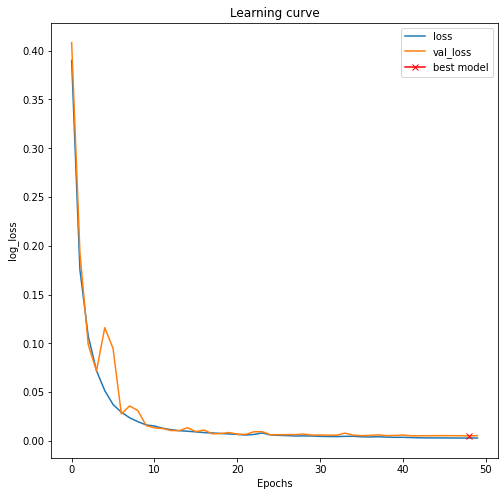

In [14]:
plt.figure(figsize=(8, 8))
plt.title('Learning curve')
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label='val_loss')
plt.plot(np.argmin(results.history['val_loss']), np.min(results.history['val_loss']), marker='x', color='r', label='best model')
plt.xlabel('Epochs')
plt.ylabel('log_loss')
plt.legend()

# Results analysis

In [15]:
test_with_abnormality = test[test['abnormality']==1]
test_with_abnormality = test_with_abnormality.reset_index(drop=True)

## Check 30 random predictions

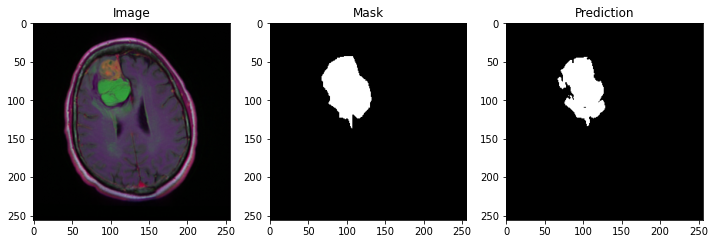

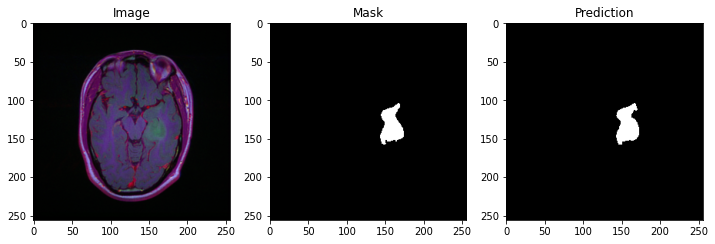

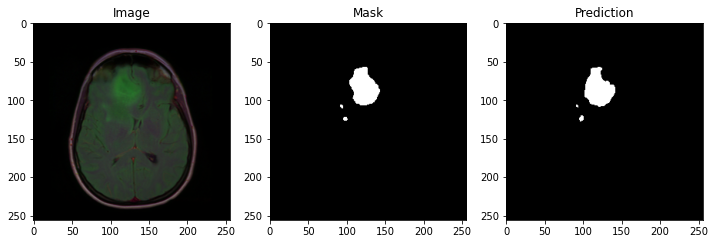

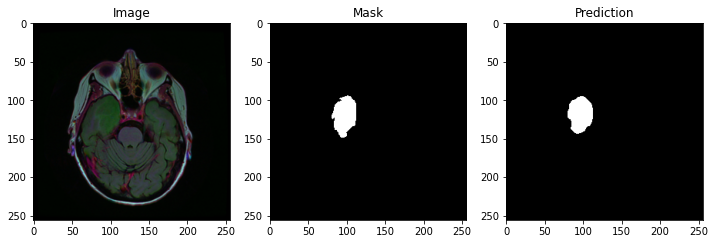

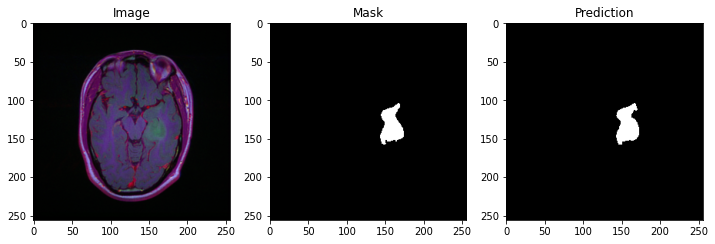

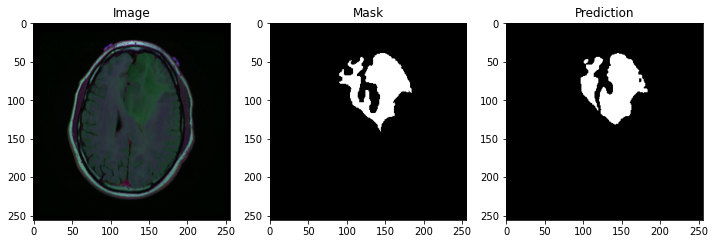

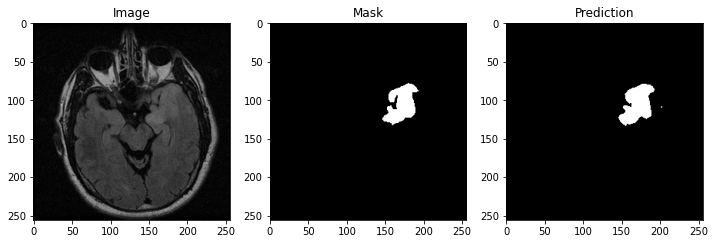

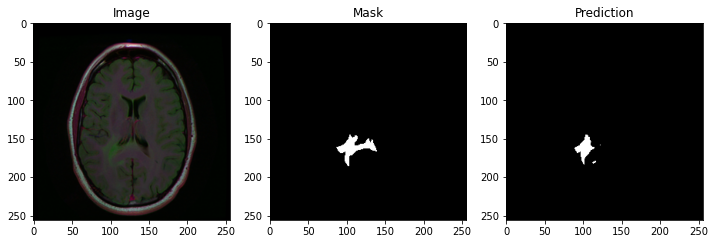

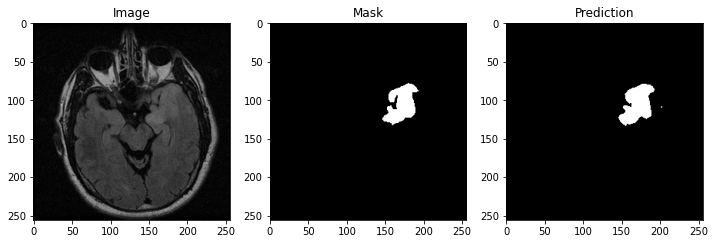

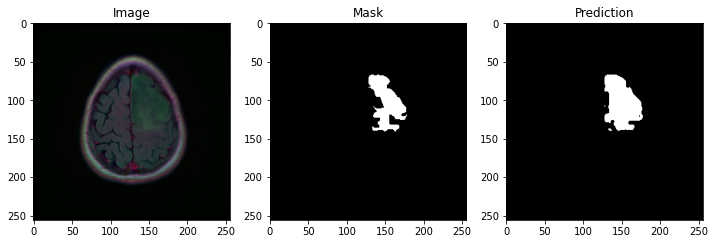

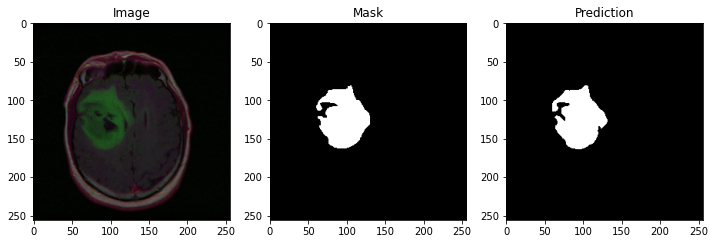

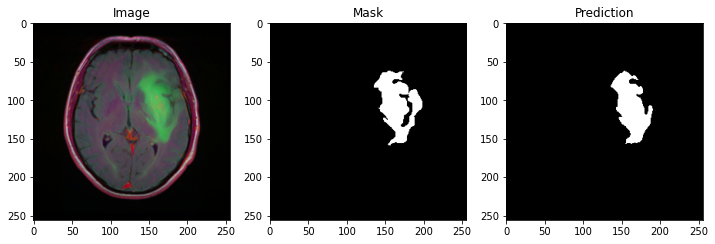

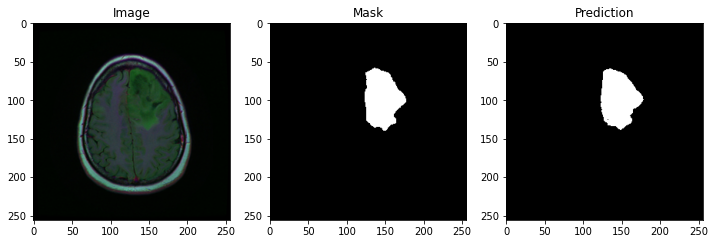

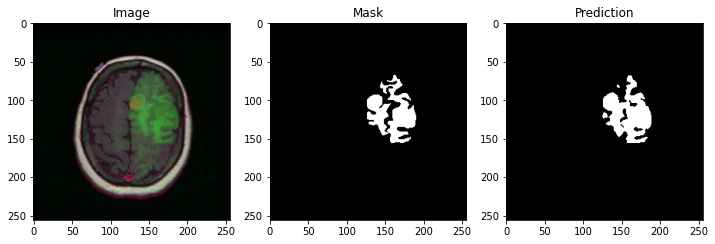

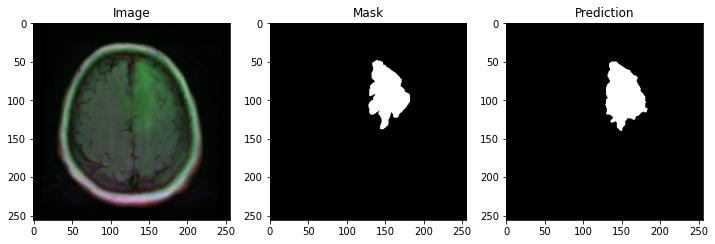

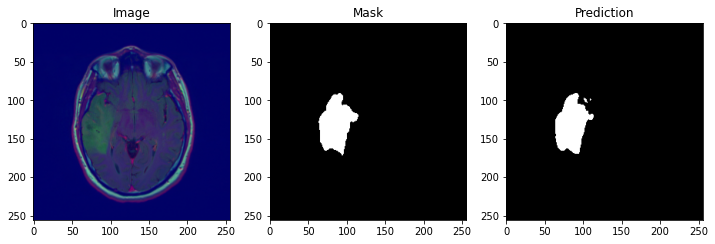

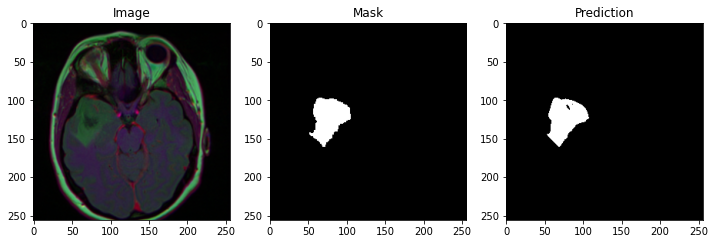

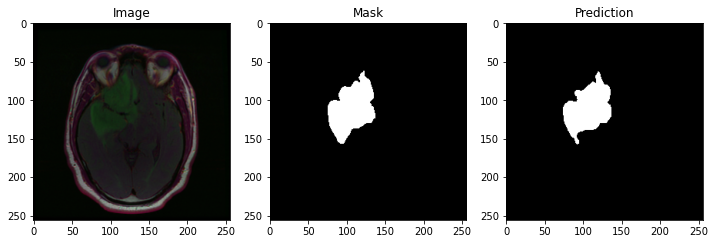

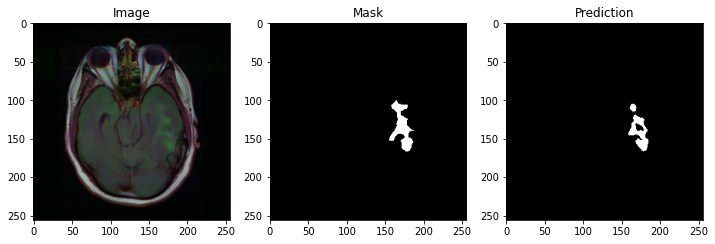

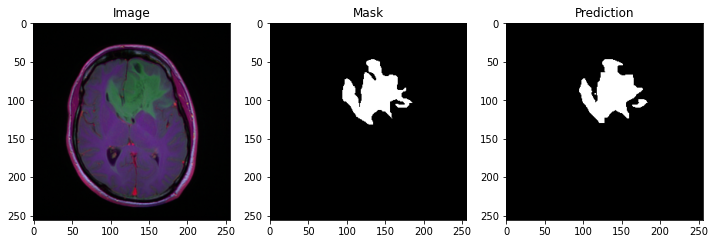

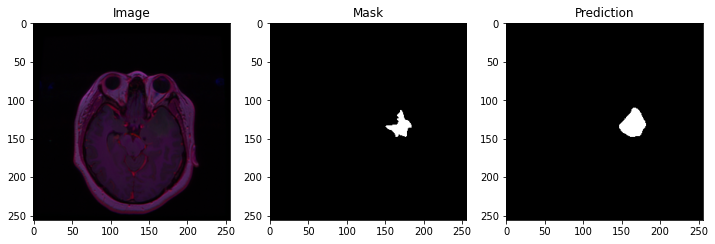

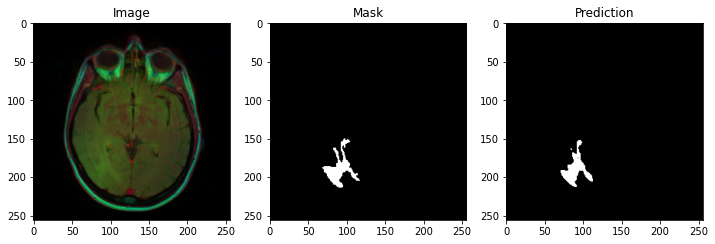

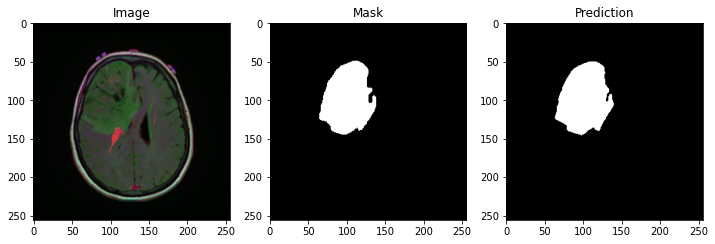

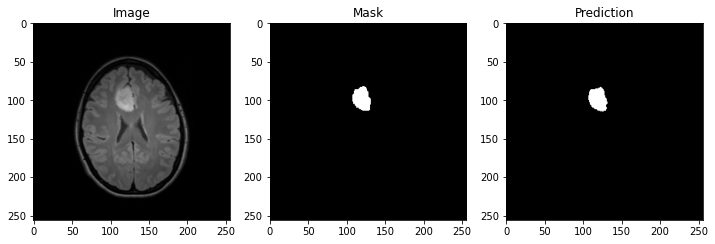

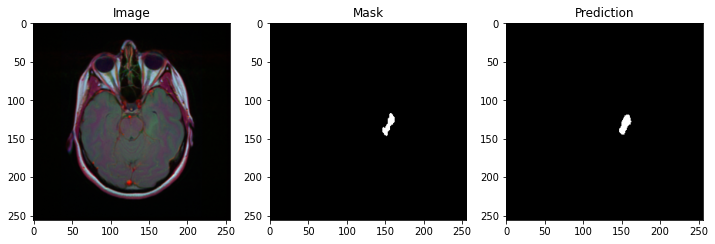

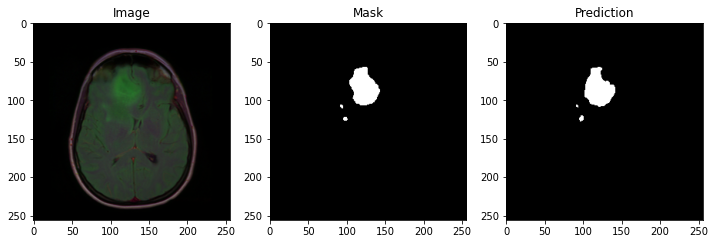

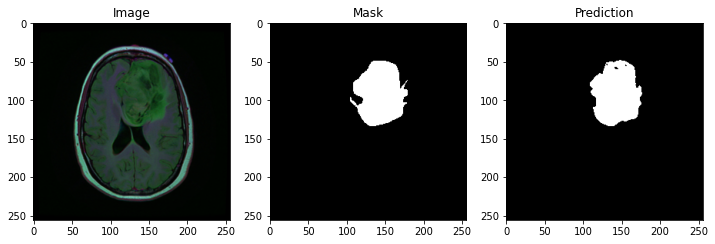

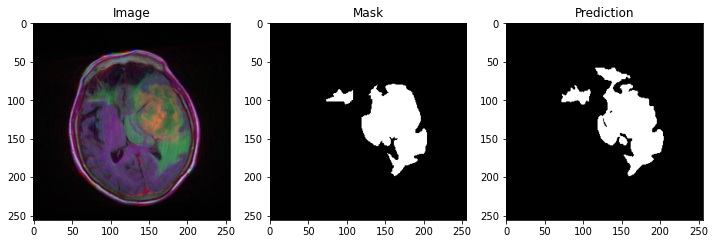

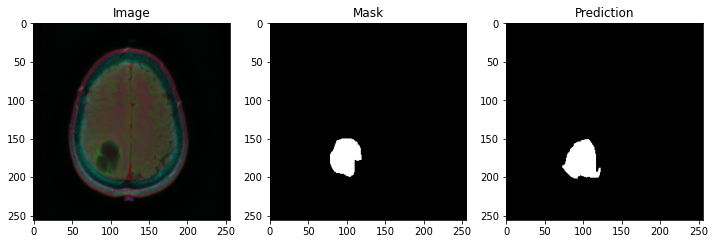

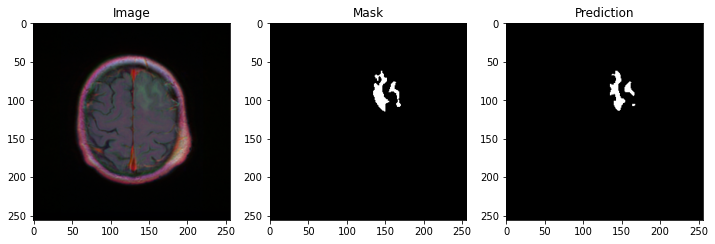

In [16]:
for i in range(30):
    index=np.random.randint(1,len(test_with_abnormality.index))
    img = cv2.imread(test_with_abnormality['image'].iloc[index])
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = np.squeeze(pred)
    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Image')
    plt.subplot(1,3,2)
    plt.imshow(cv2.imread(test_with_abnormality['mask'].iloc[index]))
    plt.title('Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.where(pred>.5, 1., 0.), cmap='gray')
    plt.title('Prediction')
    plt.show()

## Compute every IoU scores

In [17]:
scores = []

for index in tqdm(test_with_abnormality.index):
    img = cv2.imread(test_with_abnormality['image'].iloc[index])
    msk = cv2.imread(test_with_abnormality['mask'].iloc[index])
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = np.expand_dims(pred, axis=-1)
    intersection = np.logical_and(msk, pred)
    union = np.logical_or(msk, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    scores.append(iou_score)

print('Mean IoU score on the test dataset is {:#.3g} .'.format(sum(scores)/len(scores)))

100%|██████████| 206/206 [01:10<00:00,  2.93it/s]

Mean IoU score on the test dataset is 0.0305 .


## Check blank predictions

In [18]:
for index in [index for index in range(len(scores)) if scores[index]==0.]:
    img = cv2.imread(test_with_abnormality['image'].iloc[index])
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = np.squeeze(pred)
    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Image')
    plt.subplot(1,3,2)
    plt.imshow(cv2.imread(test_with_abnormality['mask'].iloc[index]))
    plt.title('Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.where(pred>.5, 1., 0.), cmap='gray')
    plt.title('Prediction')
    plt.show()

## Check top-15 predictions

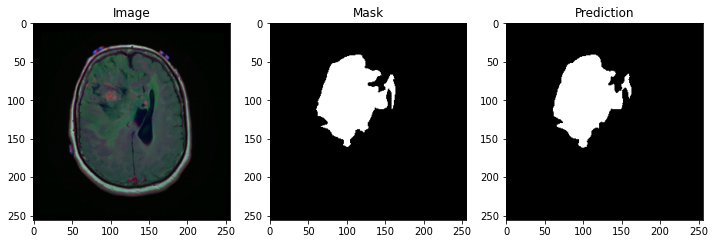

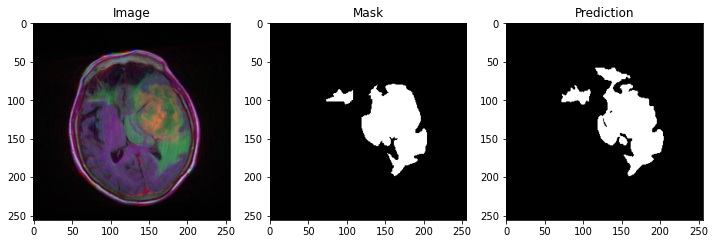

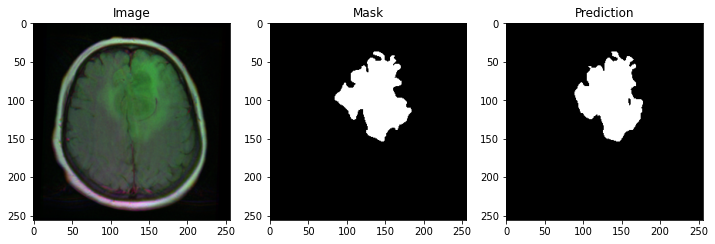

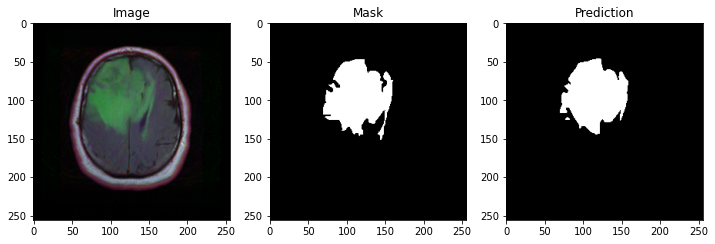

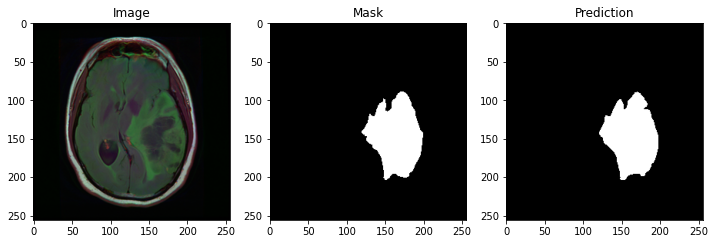

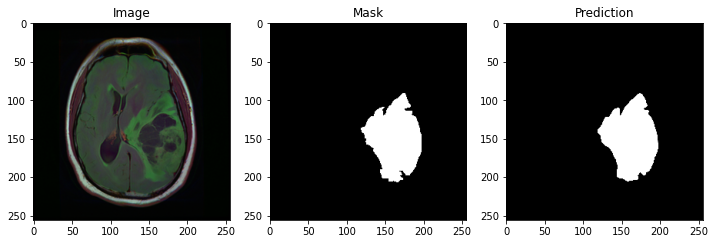

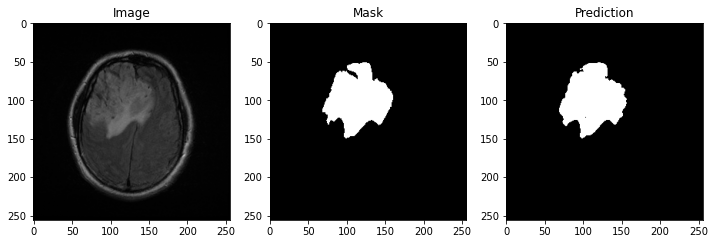

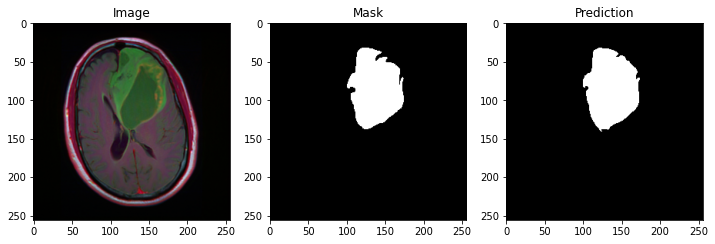

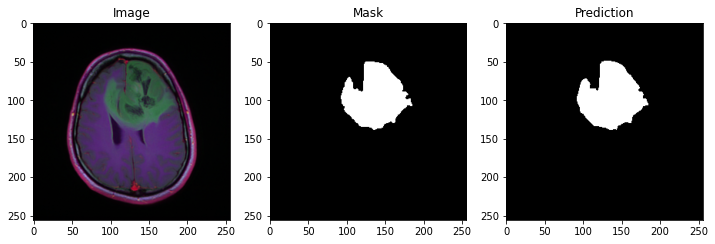

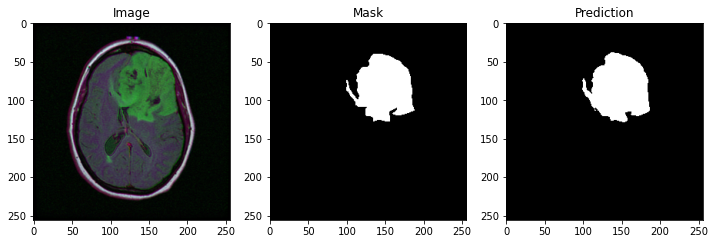

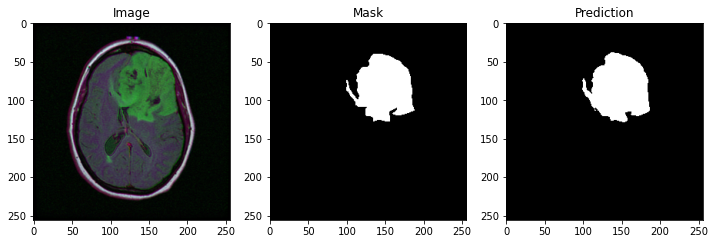

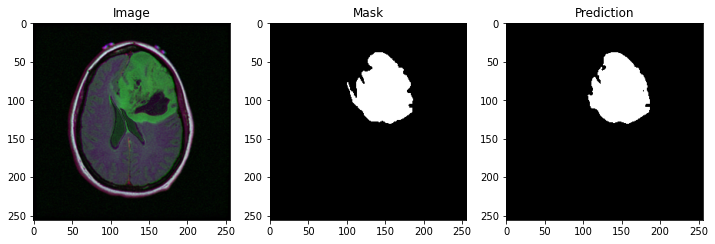

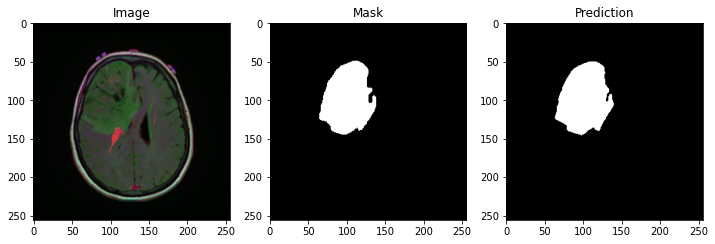

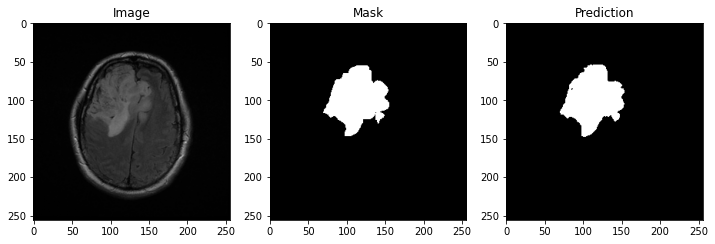

In [19]:
for top_score in sorted(scores)[-1:-15:-1]:
    index = scores.index(top_score)
    img = cv2.imread(test_with_abnormality['image'].iloc[index])
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = np.squeeze(pred)
    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Image')
    plt.subplot(1,3,2)
    plt.imshow(cv2.imread(test_with_abnormality['mask'].iloc[index]))
    plt.title('Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.where(pred>.5, 1., 0.), cmap='gray')
    plt.title('Prediction')
    plt.show()